<b>Important:</b> Save prepared/modified datasets locally to <code>../data/prepared/</code>


In [25]:
import sys
import pandas as pd
sys.path.insert(1, '../../../../utils')
from numpy import log, ndarray, array
from pandas import read_csv, DataFrame, Series, concat
from matplotlib.pyplot import figure, savefig, show, subplots
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from dslabs_functions import evaluate_approach, plot_multiline_chart, plot_bar_chart, get_variable_types, plot_multibar_chart, define_grid, derive_date_variables, HEIGHT, plot_multi_scatters_chart, dummify, CLASS_EVAL_METRICS, DELTA_IMPROVE, plot_evaluation_results, run_NB, run_KNN, CLASS_EVAL_METRICS
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from sklearn.impute import SimpleImputer
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from typing import Dict

In [42]:
file_tag = "flight_cancellations"
filename = "../../data/raw/Combined_Flights_2022_removed_leaks.csv"
data: DataFrame = read_csv(filename, na_values="")

origin_states = set(data["OriginState"].dropna().unique())
dest_states   = set(data["DestState"].dropna().unique())

all_states = sorted(origin_states.union(dest_states))

airport_counts = (
    data["Origin"].value_counts()
    + data["Dest"].value_counts()
).fillna(0)

# manual thresholds, setting before sampling
LARGE_THRESHOLD = 150_000
MEDIUM_THRESHOLD = 50_000
SMALL_THRESHOLD = 10_000

def classify_hub(count: float) -> int:
    if count >= LARGE_THRESHOLD:
        return 0    # large hub
    elif count >= MEDIUM_THRESHOLD:
        return 1    # medium hub
    elif count >= SMALL_THRESHOLD:
        return 2    # small hub
    else:
        return 3    # non-hub

hub_series = airport_counts.map(classify_hub)
hub_rank = hub_series.to_dict()

data = data.sample(n=200_000, random_state=42).reset_index(drop=True)

In [29]:
vars_types: dict[str, list] = get_variable_types(data)
numeric: list[str] = vars_types["numeric"]
symbolic: list[str] = vars_types["symbolic"]

print("Numeric variables:", numeric)
print("Symbolic variables:", symbolic)

# inspect symbolics
for v in symbolic:
    print(f"\nVariable: {v}")
    print(data[v].unique()[:10])   # first 20 uniques

Numeric variables: ['CRSDepTime', 'CRSElapsedTime', 'Distance', 'Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'DOT_ID_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'DOT_ID_Operating_Airline', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginStateFips', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestStateFips', 'DestWac', 'CRSArrTime', 'DistanceGroup', 'DivAirportLandings']
Symbolic variables: ['Airline', 'Origin', 'Dest', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'IATA_Code_Marketing_Airline', 'Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'OriginCityName', 'OriginState', 'OriginStateName', 'DestCityName', 'DestState', 'DestStateName', 'DepTimeBlk', 'ArrTimeBlk']

Variable: Airline
['SkyWest Airlines Inc.' 'American Airlines Inc.' 'Southwest Airlines Co.'
 'Delta Air Lines Inc.' 'Hawaiian Airlines Inc.' 'Spirit Air Lines'
 'Comair Inc.'

In [43]:
'''COMMON ENCODING - will use this for all encoding cases.
   Can consider cyclical encoding for these, but keeping ordinal
   for simplicity for now.'''

timeblk_order: list[str] = [
    "0001-0559", "0600-0659", "0700-0759", "0800-0859", "0900-0959",
    "1000-1059", "1100-1159", "1200-1259", "1300-1359", "1400-1459",
    "1500-1559", "1600-1659", "1700-1759", "1800-1859", "1900-1959",
    "2000-2059", "2100-2159", "2200-2259", "2300-2359"
]

DepTimeBlk_values: dict[str, int] = {v: i for i, v in enumerate(timeblk_order)}
ArrTimeBlk_values: dict[str, int] = {v: i for i, v in enumerate(timeblk_order)}



# Encoding Method 1

In [44]:
target: str = "Cancelled"

df_enc1: DataFrame = data.copy()

encoding_A: dict[str, dict] = {}

# coding for the time blocks
if "DepTimeBlk" in symbolic:
    encoding_A["DepTimeBlk"] = DepTimeBlk_values
if "ArrTimeBlk" in symbolic:
    encoding_A["ArrTimeBlk"] = ArrTimeBlk_values

# dummy symbolic with <= 40 unique values
max_dummies = 40
vars_to_dummify: list[str] = []

for v in symbolic:
    if v in ["DepTimeBlk", "ArrTimeBlk"]:
        continue
    if v == target:
        continue
    nunique = df_enc1[v].nunique(dropna=True)
    if nunique <= max_dummies:
        vars_to_dummify.append(v)

print("Will ONE-HOT these symbolic vars in enc1:", vars_to_dummify)

# ordinal encooding for rest of symbolic vars
for v in symbolic:
    if v in encoding_A:          
        continue
    if v == target:
        continue
    if v in vars_to_dummify:     
        continue

    vals = list(df_enc1[v].dropna().unique())
    vals.sort()
    encoding_A[v] = {val: i for i, val in enumerate(vals)}

# apply mappings
df_enc1 = df_enc1.replace(encoding_A, inplace=False)

# apply dummification
if len(vars_to_dummify) > 0:
    df_enc1 = dummify(df_enc1, vars_to_dummify)

print("Finished updated df_enc1 encoding (one-hot for most symbolics).")
display(df_enc1.head())

Will ONE-HOT these symbolic vars in enc1: ['Airline', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'IATA_Code_Marketing_Airline', 'Operating_Airline', 'IATA_Code_Operating_Airline']
Finished updated df_enc1 encoding (one-hot for most symbolics).


,FlightDate,Origin,Dest,Cancelled,CRSDepTime,CRSElapsedTime,Distance,Year,Quarter,Month,...,IATA_Code_Operating_Airline_NK,IATA_Code_Operating_Airline_OH,IATA_Code_Operating_Airline_OO,IATA_Code_Operating_Airline_PT,IATA_Code_Operating_Airline_QX,IATA_Code_Operating_Airline_UA,IATA_Code_Operating_Airline_WN,IATA_Code_Operating_Airline_YV,IATA_Code_Operating_Airline_YX,IATA_Code_Operating_Airline_ZW
0,2022-03-19,22,96,False,1831,62.0,125.0,2022,1,3,...,False,False,True,False,False,False,False,False,False,False
1,2022-02-16,360,96,False,1605,212.0,1162.0,2022,1,2,...,False,False,True,False,False,False,False,False,False,False
2,2022-01-18,194,248,False,1719,330.0,2486.0,2022,1,1,...,False,False,False,False,False,False,False,False,False,False
3,2022-01-23,192,59,False,1515,260.0,2106.0,2022,1,1,...,False,False,False,False,False,False,True,False,False,False
4,2022-07-01,105,294,False,715,98.0,501.0,2022,3,7,...,False,False,False,False,False,False,False,False,False,False


# Encoding Method 2

In [45]:
'''Hierachical Encoding for OriginState and DestState'''

region_code = {
    # west (0)
    "WA": 0, "OR": 0, "CA": 0, "NV": 0, "ID": 0, "MT": 0,
    "WY": 0, "UT": 0, "CO": 0, "AZ": 0, "NM": 0, "AK": 0,
    "HI": 0,

    # midwest (1)
    "ND": 1, "SD": 1, "NE": 1, "KS": 1, "MN": 1, "IA": 1,
    "MO": 1, "WI": 1, "IL": 1, "IN": 1, "MI": 1, "OH": 1,

    # south (2)
    "DE": 2, "MD": 2, "WV": 2, "VA": 2, "KY": 2, "TN": 2,
    "NC": 2, "SC": 2, "GA": 2, "FL": 2, "AL": 2, "MS": 2,
    "AR": 2, "LA": 2, "OK": 2, "TX": 2, "PR": 2, "VI": 2,
    "TT": 2,

    # northeast (3)
    "ME": 3, "NH": 3, "VT": 3, "MA": 3, "RI": 3, "CT": 3,
    "NY": 3, "NJ": 3, "PA": 3,
}

coastal = {
    # pacific coast
    "CA": 1, "OR": 1, "WA": 1, "AK": 1, "HI": 1, 

    # atlantic coast
    "ME": 1, "NH": 1, "MA": 1, "RI": 1, "CT": 1,
    "NY": 1, "NJ": 1, "DE": 1, "MD": 1, "VA": 1,
    "NC": 1, "SC": 1, "GA": 1, "FL": 1, "PR": 1,
    "VI": 1, "TT": 1,

    # gulf coast
    "TX": 1, "LA": 1, "MS": 1, "AL": 1,

    # all others get 0 
}

great_lakes = {
    "MN": 1, "WI": 1, "IL": 1, "IN": 1, "MI": 1, "OH": 1,
    "PA": 1, "NY": 1,

    #all others 0
}

latitude_rank = {
    "AK": 0,  "MN": 1,  "ND": 2,  "MT": 3,  "WI": 4,  "ID": 5,
    "SD": 6,  "NH": 7,  "VT": 8,  "WA": 9,  "ME": 10, "OR": 11,
    "NY": 12, "MA": 13, "MI": 14, "WY": 15, "CT": 16, "RI": 17,
    "IA": 18, "NE": 19, "PA": 20, "NJ": 21, "OH": 22, "IL": 23,
    "IN": 24, "CO": 25, "UT": 26, "NV": 27, "WV": 28, "VA": 29,
    "MO": 30, "KS": 31, "KY": 32, "MD": 33, "DE": 34, "DC": 35,
    "CA": 36, "NC": 37, "TN": 38, "OK": 39, "AZ": 40, "NM": 41,
    "AR": 42, "SC": 43, "GA": 44, "AL": 45, "MS": 46, "LA": 47,
    "TX": 48, "FL": 49, "HI": 50, "PR": 51, "VI": 52, "TT": 53,
}

state_tree_encode = {}

for state in region_code:
    r = region_code[state]
    c = coastal.get(state, 0)
    g = great_lakes.get(state, 0)
    lat = latitude_rank.get(state, 99)   # default for missing vals
    code = r*10 + c*3 + g
    state_tree_encode[state] = code

In [46]:
df_enc2 = data.copy()

# map Origin/Dest to hub rank
df_enc2["Origin"] = df_enc2["Origin"].map(hub_rank)
df_enc2["Dest"]   = df_enc2["Dest"].map(hub_rank)

encoding_B = {}

# time block encoding
if "DepTimeBlk" in symbolic:
    encoding_B["DepTimeBlk"] = DepTimeBlk_values
if "ArrTimeBlk" in symbolic:
    encoding_B["ArrTimeBlk"] = ArrTimeBlk_values

# tree-based state encoding
for state_col in ["OriginState", "DestState"]:
    if state_col in symbolic:
        encoding_B[state_col] = state_tree_encode

# ordinal encoding for the rest of the symbolic variables
for v in symbolic:
    if v in encoding_B:          # already handled (time blocks, states)
        continue
    if v == target:
        continue
    if v in ["Origin", "Dest"]:  # already mapped to hub_rank
        continue

    vals = list(df_enc2[v].dropna().unique())
    vals.sort()
    encoding_B[v] = {val: i for i, val in enumerate(vals)}

# apply explicit encodings
df_enc2 = df_enc2.replace(encoding_B, inplace=False)

print("Finished df_enc2 encoding (tree-based states, hub rank Origin/Dest, no one-hot).")
display(df_enc2.head())

Finished df_enc2 encoding (tree-based states, hub rank Origin/Dest, no one-hot).


,FlightDate,Airline,Origin,Dest,Cancelled,CRSDepTime,CRSElapsedTime,Distance,Year,Quarter,...,DestCityName,DestState,DestStateFips,DestStateName,DestWac,DepTimeBlk,CRSArrTime,ArrTimeBlk,DistanceGroup,DivAirportLandings
0,2022-03-19,17,3,0,False,1831,62.0,125.0,2022,1,...,87,0,8,5,82,13,1933,14,1,0
1,2022-02-16,17,2,0,False,1605,212.0,1162.0,2022,1,...,87,0,8,5,82,11,1737,12,5,0
2,2022-01-18,3,0,2,False,1719,330.0,2486.0,2022,1,...,169,3,15,10,2,12,2049,15,10,0
3,2022-01-23,18,0,1,False,1515,260.0,2106.0,2022,1,...,24,23,24,19,35,10,2235,17,9,0
4,2022-07-01,7,0,1,False,715,98.0,501.0,2022,3,...,278,23,37,32,36,2,853,3,3,0


In [51]:
output_path = "../../data/prepared/flight_enc.csv"
df_enc2.to_csv(output_path, index=False)
print(f"Saved Encoding 2 dataset to: {output_path}")

Saved Encoding 2 dataset to: ../../data/prepared/flight_enc.csv


# Evaluation

In [47]:
def temporary_mvi(df: DataFrame) -> DataFrame:
    '''very basic, so we can quickly compare encoding approaches.'''
    df = df.copy().reset_index(drop=True)

    target = "Cancelled"

    # separate target
    y = df[target].copy()
    X = df.drop(columns=[target])

    vars_types = get_variable_types(X)

    # drop cols completely NaN
    all_nan_cols = X.columns[X.isna().all()].tolist()
    if len(all_nan_cols) > 0:
        print("Dropping all-NaN columns:", all_nan_cols)
    X = X.drop(columns=all_nan_cols)

    # recompute types after dropping
    vars_types = get_variable_types(X)
    parts = []

    numeric_all = vars_types["numeric"]
    datetime_vars = [v for v in numeric_all if "datetime64" in str(X[v].dtype)]
    numeric_vars = [v for v in numeric_all if v not in datetime_vars]

    if len(numeric_vars) > 0:
        imp_num = SimpleImputer(strategy="median")
        df_num = DataFrame(
            imp_num.fit_transform(X[numeric_vars]),
            columns=numeric_vars,
            index=X.index,
        )
        parts.append(df_num)

    # keep datetime unchanged
    if len(datetime_vars) > 0:
        parts.append(X[datetime_vars].copy())

    symbolic_like = vars_types["symbolic"] + vars_types["binary"]
    if len(symbolic_like) > 0:
        imp_sym = SimpleImputer(strategy="most_frequent")
        df_sym = DataFrame(
            imp_sym.fit_transform(X[symbolic_like]),
            columns=symbolic_like,
            index=X.index,
        )
        parts.append(df_sym)

    # rebuild X
    if len(parts) > 0:
        df_out = concat(parts, axis=1)
    else:
        df_out = X.copy()

    # reattach target col
    df_out[target] = y.values

    return df_out


In [48]:
target = "Cancelled"

# sort by date here to ensure consistent splits
df_enc1_sorted = df_enc1.sort_values("FlightDate").reset_index(drop=True)
df_enc2_sorted = df_enc2.sort_values("FlightDate").reset_index(drop=True)

# train/test split (70/30)
split_idx = int(0.7 * len(df_enc1_sorted))

train1_raw = df_enc1_sorted.iloc[:split_idx].copy()
test1_raw  = df_enc1_sorted.iloc[split_idx:].copy()

train2_raw = df_enc2_sorted.iloc[:split_idx].copy()
test2_raw  = df_enc2_sorted.iloc[split_idx:].copy()

print("Shapes enc1:", train1_raw.shape, test1_raw.shape)
print("Shapes enc2:", train2_raw.shape, test2_raw.shape)

# 3) Apply temporary MVI ONCE per split
train1 = temporary_mvi(train1_raw)
test1  = temporary_mvi(test1_raw)

train2 = temporary_mvi(train2_raw)
test2  = temporary_mvi(test2_raw)

print("Temporary MVI applied to train/test for both encodings.")

def extract_nb_knn_scores(eval_dict: Dict, metric: str = "recall") -> list[float]:
    """
    Take evaluate_approach output and return [NB_score, KNN_score] for a given metric.
    Handles:
      - eval_dict["NB"] being a scalar
      - eval_dict["NB"] being a list/tuple
      - eval_dict["NB"] being a numpy array
      - eval_dict["NB"] being a dict of metrics, e.g. {"recall": 0.8, "accuracy": 0.9}
    """
    scores: list[float] = []
    for model in ["NB", "KNN"]:
        val = eval_dict[model]

        # case: dict of metrics: {'recall': ..., 'accuracy': ...}
        if isinstance(val, dict):
            if metric in val:
                v = val[metric]
            else:
                # fallback to the first metric if metric key missing
                v = next(iter(val.values()))
        else:
            v = val

        # normalize to a single float
        if isinstance(v, ndarray):
            v = float(v.ravel()[0])
        elif isinstance(v, (list, tuple)):
            v = float(v[0])
        else:
            v = float(v)

        scores.append(v)

    return scores

Shapes enc1: (140000, 135) (60000, 135)
Shapes enc2: (140000, 44) (60000, 44)
Temporary MVI applied to train/test for both encodings.


In [49]:
def evaluate_approach(
    train: DataFrame,
    test: DataFrame,
    target: str = "Cancelled",
    metric: str = "recall",
) -> dict[str, list[float]]:
    """
    Local version that matches the professor's definition:
    returns a dict[metric_name] = [NB_value, KNN_value]
    suitable for plot_multibar_chart(["NB","KNN"], eval, ...).
    """
    trn = train.copy()
    tst = test.copy()

    trnY = trn.pop(target).values
    trnX: ndarray = trn.values
    tstY = tst.pop(target).values
    tstX: ndarray = tst.values

    eval_dict: dict[str, list[float]] = {}

    eval_NB  = run_NB(trnX, trnY, tstX, tstY, metric=metric)
    eval_KNN = run_KNN(trnX, trnY, tstX, tstY, metric=metric)

    if eval_NB and eval_KNN:
        for met in CLASS_EVAL_METRICS:
            eval_dict[met] = [eval_NB[met], eval_KNN[met]]

    return eval_dict

def print_eval_table(eval_dict: dict[str, list[float]]):
    """
    Pretty-print evaluation metrics for NB and KNN with 4 decimal places.
    Assumes eval_dict[metric] = [NB_value, KNN_value]
    """
    print("\n=== MODEL METRIC SUMMARY (NB vs KNN) ===")
    print(f"{'Metric':12s} | {'NB':>10s} | {'KNN':>10s}")
    print("-" * 40)
    for metric, vals in eval_dict.items():
        nb, knn = vals
        print(f"{metric:12s} | {nb:10.4f} | {knn:10.4f}")
    print()


=== ENCODING EVALUATION (NB + KNN) ===

=== MODEL METRIC SUMMARY (NB vs KNN) ===
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.5690 |     0.9524
recall       |     0.5344 |     0.0909
precision    |     0.0279 |     0.0703
auc          |     0.5521 |     0.5316
f1           |     0.0530 |     0.0793



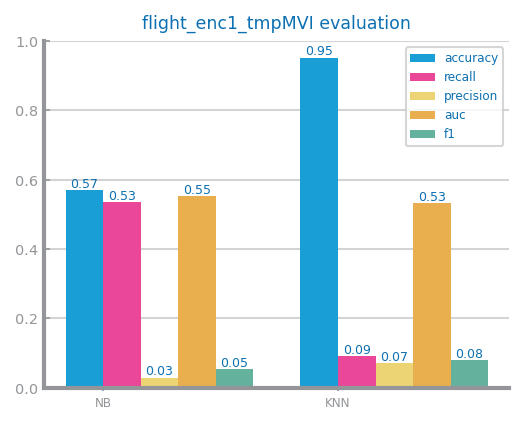


=== MODEL METRIC SUMMARY (NB vs KNN) ===
Metric       |         NB |        KNN
----------------------------------------
accuracy     |     0.5696 |     0.9524
recall       |     0.5322 |     0.0909
precision    |     0.0278 |     0.0703
auc          |     0.5513 |     0.5316
f1           |     0.0528 |     0.0793



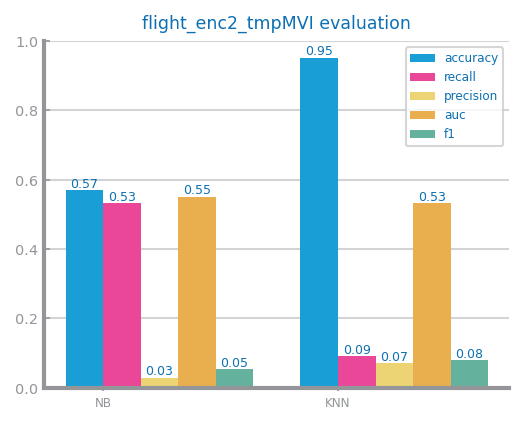

In [50]:
print("\n=== ENCODING EVALUATION (NB + KNN) ===")

file_tag1 = "flight_enc1_tmpMVI"
file_tag2 = "flight_enc2_tmpMVI"
target    = "Cancelled"

# Encoding 1
figure()
eval1 = evaluate_approach(
    train1_eval.copy(),
    test1_eval.copy(),
    target=target,
    metric="recall",
)
print_eval_table(eval1)
plot_multibar_chart(
    ["NB", "KNN"],
    eval1,
    title=f"{file_tag1} evaluation",
    percentage=True,
)
savefig(f"../../charts/lab3_preparation/{file_tag1}_NB_KNN_recall_eval.png")
show()

# Encoding 2
figure()
eval2 = evaluate_approach(
    train2_eval.copy(),
    test2_eval.copy(),
    target=target,
    metric="recall",
)
print_eval_table(eval2)
plot_multibar_chart(
    ["NB", "KNN"],
    eval2,
    title=f"{file_tag2} evaluation",
    percentage=True,
)
savefig(f"../../charts/lab3_preparation/{file_tag2}_NB_KNN_recall_eval.png")
show()


In [ ]:
print("train2_eval COLUMNS:\n", train2_eval.columns.tolist())
print("test2_eval COLUMNS:\n", test2_eval.columns.tolist())

file_tag = "flight_cancellations_enc2"
target = "Cancelled"
eval_metric = "accuracy"  

# work from the already-prepared eval sets for enc2
train_df = train2_eval.copy()
test_df  = test2_eval.copy()

trnY = train_df[target].values
tstY = test_df[target].values

trnX = train_df.drop(columns=[target]).values
tstX = test_df.drop(columns=[target]).values

labels = sorted(list(set(trnY) | set(tstY)))
print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

train2_eval COLUMNS:
 ['Airline', 'Origin', 'Dest', 'CRSDepTime', 'DepTime', 'DepDelayMinutes', 'ArrTime', 'ArrDelayMinutes', 'AirTime', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance', 'Year', 'Month', 'DayofMonth', 'DayOfWeek', 'Marketing_Airline_Network', 'Operated_or_Branded_Code_Share_Partners', 'DOT_ID_Marketing_Airline', 'IATA_Code_Marketing_Airline', 'Flight_Number_Marketing_Airline', 'Operating_Airline', 'DOT_ID_Operating_Airline', 'IATA_Code_Operating_Airline', 'Tail_Number', 'Flight_Number_Operating_Airline', 'OriginAirportID', 'OriginAirportSeqID', 'OriginCityMarketID', 'OriginCityName', 'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac', 'DestAirportID', 'DestAirportSeqID', 'DestCityMarketID', 'DestCityName', 'DestState', 'DestStateFips', 'DestStateName', 'DestWac', 'DepTimeBlk', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'TaxiIn', 'CRSArrTime', 'ArrTimeBlk', 'DistanceGroup', 'DivAirportLandings', 'Diverted', 'Quarter', 'DepDel15', 'ArrDel15', 'Cancelled']
test2_e

<Figure size 600x450 with 0 Axes>

Best NB params: {'name': 'MultinomialNB', 'metric': 'recall', 'params': (), 'recall': 0.5609756097560976}


<Figure size 600x450 with 0 Axes>

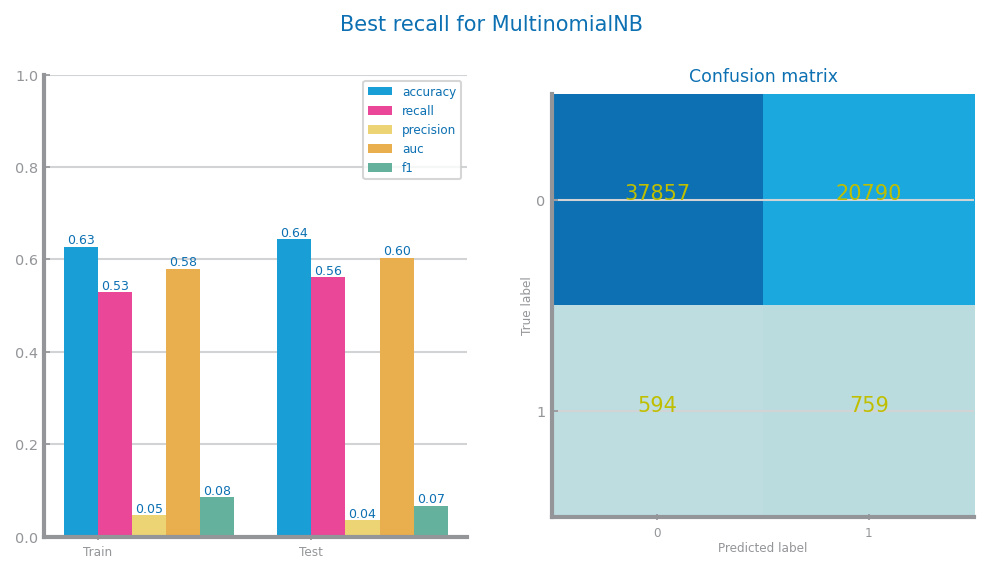

In [19]:
def naive_Bayes_study(
    trnX: ndarray, trnY: array, tstX: ndarray, tstY: array, metric: str = "accuracy"
) -> tuple:
    estimators: dict = {
        "GaussianNB": GaussianNB(),
        "MultinomialNB": MultinomialNB(),
        "BernoulliNB": BernoulliNB(),
    }

    xvalues: list[str] = []
    yvalues: list[float] = []
    best_model = None
    best_params: dict = {"name": "", "metric": metric, "params": ()}
    best_performance: float = 0.0

    for clf_name in estimators:
        xvalues.append(clf_name)
        clf = estimators[clf_name]
        clf.fit(trnX, trnY)
        prdY: array = clf.predict(tstX)
        eval_val: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
        if eval_val - best_performance > DELTA_IMPROVE:
            best_performance = eval_val
            best_params["name"] = clf_name
            best_params[metric] = eval_val
            best_model = clf
        yvalues.append(eval_val)

    return best_model, best_params

# nb study on best enc2 dataset
figure()
best_nb_model, nb_params = naive_Bayes_study(trnX, trnY, tstX, tstY, metric=eval_metric)
savefig(f"../../charts/lab3_preparation/{file_tag}_nb_{eval_metric}_study.png")
show()

print("Best NB params:", nb_params)

# confusion matrices + metrics for best NB
prd_trn_nb: array = best_nb_model.predict(trnX)
prd_tst_nb: array = best_nb_model.predict(tstX)

figure()
plot_evaluation_results(nb_params, trnY, prd_trn_nb, tstY, prd_tst_nb, labels)
savefig(f"../../charts/lab3_preparation/{file_tag}_nb_{nb_params['name']}_best_{nb_params['metric']}_eval.png")
show()

In [20]:
def knn_study(
    trnX: ndarray,
    trnY: array,
    tstX: ndarray,
    tstY: array,
    k_max: int = 19,
    lag: int = 2,
    metric: str = "accuracy",
) -> tuple[KNeighborsClassifier | None, dict]:
    dist: list[Literal["manhattan", "euclidean", "chebyshev"]] = [
        "manhattan",
        "euclidean",
        "chebyshev",
    ]

    kvalues: list[int] = [i for i in range(1, k_max + 1, lag)]
    best_model: KNeighborsClassifier | None = None
    best_params: dict = {"name": "KNN", "metric": metric, "params": ()}
    best_performance: float = 0.0

    values: dict[str, list] = {}
    for d in dist:
        y_tst_values: list = []
        for k in kvalues:
            clf = KNeighborsClassifier(n_neighbors=k, metric=d)
            clf.fit(trnX, trnY)
            prdY: array = clf.predict(tstX)
            eval_val: float = CLASS_EVAL_METRICS[metric](tstY, prdY)
            y_tst_values.append(eval_val)
            if eval_val - best_performance > DELTA_IMPROVE:
                best_performance = eval_val
                best_params["params"] = (k, d)
                best_model = clf
        values[d] = y_tst_values

    print(
        f'KNN best with k={best_params["params"][0]} and '
        f'{best_params["params"][1]} ({metric}={best_performance:.4f})'
    )

    plot_multiline_chart(
        kvalues,
        values,
        title=f"KNN Models ({metric})",
        xlabel="k",
        ylabel=metric,
        percentage=True,
    )

    return best_model, best_params

Train#=140000 Test#=60000
Labels=[np.int64(0), np.int64(1)]
KNN best with k=3 and manhattan (accuracy=0.9774)


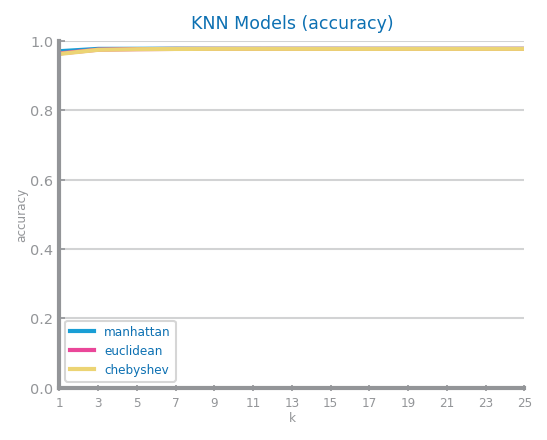

In [21]:
file_tag = "flight_cancellations_enc2"
eval_metric = "accuracy"   # keep consistent with prof code

print(f"Train#={len(trnX)} Test#={len(tstX)}")
print(f"Labels={labels}")

figure()
best_knn, knn_params = knn_study(trnX, trnY, tstX, tstY, k_max=25, metric=eval_metric)


<Figure size 600x450 with 0 Axes>

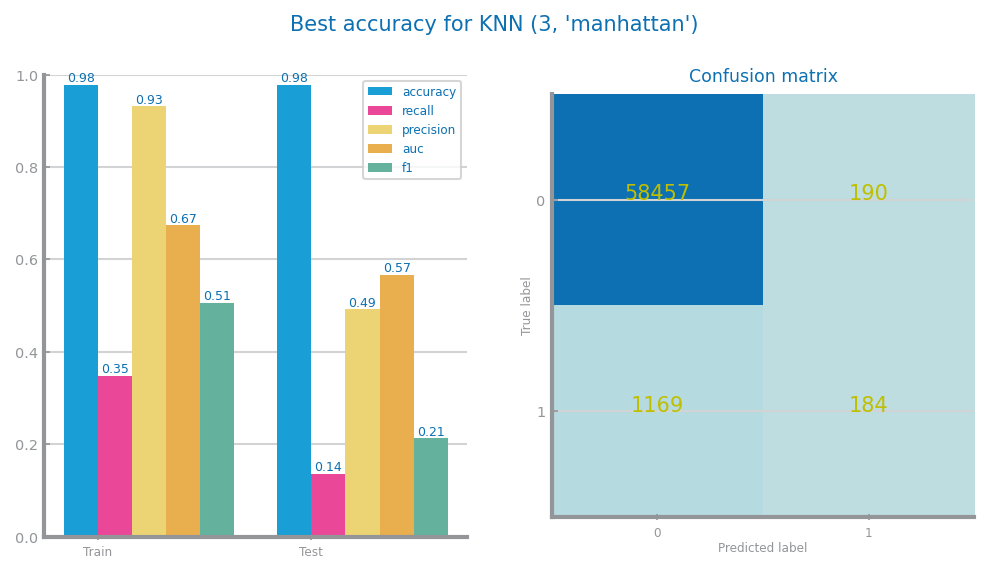

In [22]:
# predictions with the best KNN model
prd_trn_knn = best_knn.predict(trnX)
prd_tst_knn = best_knn.predict(tstX)

figure()
plot_evaluation_results(
    knn_params,   # {'name': 'KNN', 'metric': 'recall', 'params': (k, distance)}
    trnY,
    prd_trn_knn,
    tstY,
    prd_tst_knn,
    labels,
)
savefig(f"../../charts/lab3_preparation/{file_tag}_knn_{knn_params['name']}_best_{knn_params['metric']}_eval.png")
show()
